In [ ]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os
from os import listdir

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [66]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['count_region']
        
        # читаем картинку. read the image
        image = cv2.imread(f"/content/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [67]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [75]:
# читаем датасет
data_df = pd.read_csv("/content/train.csv")

In [76]:
data_df.head(3)

,ID_img,count_region,region_shape
0,3376.JPG,0.0,0.0
1,3377.JPG,0.0,0.0
2,3378.JPG,0.0,0.0


In [85]:
print("Обучающей выборки " ,len(listdir("/content/train")))
#print("Тестовой выборки " ,len(listdir("/content/test")))

Обучающей выборки  74


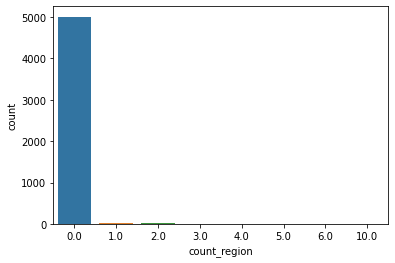

In [19]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "count_region" , data  = data_df)

In [ ]:
data_df.count_region.value_counts()

0.0     5006
2.0       31
1.0       16
5.0        3
4.0        3
3.0        3
10.0       1
6.0        1
Name: count_region, dtype: int64

Обратим внимание, что фотографи на которых присутвуют люди не много, по этому сначала обучим нейросеть отличать фотографии с людьми от фотогафий где никого нет 

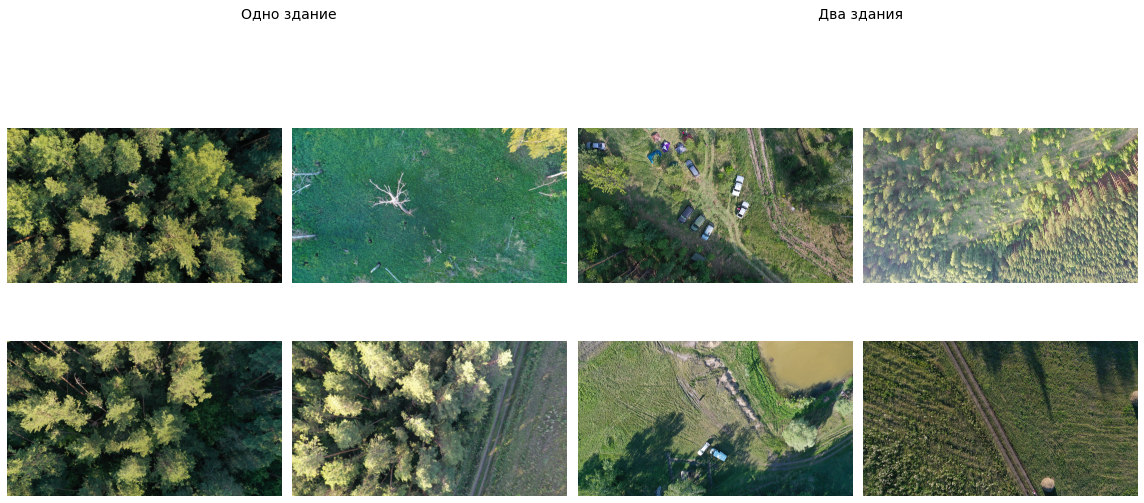

In [53]:
# посмотрим на картинки. 

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Одно здание {" "*105} Два здания', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['count_region'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['count_region'] >=1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [86]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [87]:
train_df.shape, valid_df.shape

((11, 3), (3, 3))

In [88]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [89]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [70]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [71]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [72]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

In [61]:
import gc

gc.collect()

17097

In [62]:
torch.cuda.empty_cache()

In [63]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 25)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [64]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [91]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 3)

100%|██████████| 3/3 [00:12<00:00,  4.23s/it]

Train loss: 9.658309546383945
Val loss: 38.8752818107605
Train acc: tensor(36.3636, device='cuda:0')
Val acc: tensor(66.6667, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

In [93]:
valid_df["pred"] = valid_predicts

In [94]:
valid_df

,ID_img,count_region,region_shape,pred
1,3377.JPG,0.0,0.0,0
787,4163.JPG,2.0,"['{""cx"":3321,""cy"":924,""r"":50}', '{""cx"":3277,""c...",0
2,3378.JPG,0.0,0.0,2


# Посчитаем точность

In [95]:
from sklearn.metrics import recall_score

In [ ]:
valid_df['pred'].values

In [99]:
val_accuracy = recall_score(valid_df['count_region'].values, valid_df['pred'].values, average='macro', zero_division  =0 )
print(f"Validation recall = {val_accuracy}")

Validation recall = 0.25


## Предскажем для теста

In [102]:
test_df = pd.read_csv("/content/sample_solution.csv")[:4]
test_df = test_df.drop(["region_shape"], axis = 1)

In [103]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(f"/content/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [104]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [105]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [106]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Сделаем  нулевую область под найденные обьекты

In [114]:
mass = [0 for x in range(test_df.shape[0])]

for i in range(len(predicts)):
  if predicts[i] !=0:
    mass[i] = ['{"cx":0, "cy":0, "r":0}' for x in range(predicts[i])]


In [115]:
test_df["region_shape"] = mass

test_df.head(3)

,ID_img,region_shape
0,0.JPG,0
1,1.JPG,0
2,2.JPG,"[{""cx"":0, ""cy"":0, ""r"":0}, {""cx"":0, ""cy"":0, ""r""..."


In [116]:
test_df.to_csv("submit.csv", index=False)